<a href="https://colab.research.google.com/github/selim679/Emotion_detection/blob/main/copie__2__projet_ia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q transformers==4.39.0 text_hammer kagglehub


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 43.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pysal 25.7 requires beautifulsoup4>=4.10, but you have beautifulsoup4 4.9.1 which is incompatible.
yfinance 0.2.66 requires beautifulsoup4>=4.11.1, but you have beautifulsoup4 4.9.1 which is incompatible.
sentence-transformers 5.2.0 requires transformers<6.0.0,>=4.41.0, but you have transformers 4.39.0 which is incompatible.
libpysal 4.13.0 requires beautifulsoup4>=4.10, but you have beautifulsoup4 4.9.1 which is incompatible.


In [ ]:
import os
import shutil
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
import text_hammer as th
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalMaxPool1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from transformers import AutoTokenizer, TFBertModel

warnings.filterwarnings("ignore")


In [ ]:
import kagglehub

path = kagglehub.dataset_download("pashupatigupta/emotion-detection-from-text")
print(path)


100%|██████████| 1.56M/1.56M [00:00<00:00, 105MB/s]

Extracting files...
/root/.cache/kagglehub/datasets/pashupatigupta/emotion-detection-from-text/versions/1


In [ ]:
import pandas as pd
import os

# Charger le dataset
df = pd.read_csv(os.path.join(path, "tweet_emotions.csv"))
df = df.rename(columns={"content": "text", "sentiment": "label"})

# Supprimer les lignes vides si nécessaire
df = df[df['label'] != 'empty'].reset_index(drop=True)

# Encoder automatiquement les labels en nombres
df['label'] = df['label'].astype('category')
df['label_code'] = df['label'].cat.codes

# Vérifier les labels uniques
print("Labels réels du dataset :", df['label'].unique())
print("Codes correspondants :", df[['label', 'label_code']].drop_duplicates())


Labels réels du dataset : ['sadness', 'enthusiasm', 'neutral', 'worry', 'surprise', ..., 'hate', 'happiness', 'boredom', 'relief', 'anger']
Length: 12
Categories (12, object): ['anger', 'boredom', 'enthusiasm', 'fun', ..., 'relief', 'sadness',
                          'surprise', 'worry']
Codes correspondants :           label  label_code
0       sadness           9
2    enthusiasm           2
3       neutral           7
4         worry          11
13     surprise          10
15         love           6
20          fun           3
29         hate           5
39    happiness           4
109     boredom           1
143      relief           8
481       anger           0


In [ ]:
df.head()

,tweet_id,label,text,label_code
0,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...,9
1,1956967696,sadness,Funeral ceremony...gloomy friday...,9
2,1956967789,enthusiasm,wants to hang out with friends SOON!,2
3,1956968416,neutral,@dannycastillo We want to trade with someone w...,7
4,1956968477,worry,Re-pinging @ghostridah14: why didn't you go to...,11


In [ ]:
def clean_text(text):
    text = str(text).lower()
    text = th.cont_exp(text)
    text = th.remove_emails(text)
    text = th.remove_html_tags(text)
    text = th.remove_special_chars(text)
    text = th.remove_accented_chars(text)
    return text

df['text'] = df['text'].apply(clean_text)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df['text'],
    df['label_code'],      # utiliser le code automatique
    test_size=0.3,
    random_state=42,
    stratify=df['label_code']
)


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
bert = TFBertModel.from_pretrained("bert-base-cased")


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
from transformers import AutoTokenizer

MAX_LEN = 70
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

x_train = tokenizer(
    X_train.tolist(),
    max_length=MAX_LEN,
    padding='max_length',
    truncation=True,
    return_tensors='tf'
)

x_test = tokenizer(
    X_test.tolist(),
    max_length=MAX_LEN,
    padding='max_length',
    truncation=True,
    return_tensors='tf'
)


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model

input_ids = Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_ids")
attention_mask = Input(shape=(MAX_LEN,), dtype=tf.int32, name="attention_mask")

# utiliser CLS token comme représentation
def bert_layer(inputs):
    ids, mask = inputs
    output = bert(ids, attention_mask=mask)[0]
    return output[:, 0, :]   # CLS token

bert_output = tf.keras.layers.Lambda(
    bert_layer,
    output_shape=(bert.config.hidden_size,)
)([input_ids, attention_mask])

x = Dense(128, activation="relu")(bert_output)
x = Dropout(0.3)(x)
x = Dense(32, activation="relu")(x)

output = Dense(df['label_code'].nunique(), activation="softmax")(x)  # nombre de classes réelles

model = Model(inputs=[input_ids, attention_mask], outputs=output)


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical

optimizer = Adam(learning_rate=2e-5)
model.compile(
    optimizer=optimizer,
    loss=CategoricalCrossentropy(),
    metrics=[CategoricalAccuracy(name="accuracy")]
)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ids           │ (None, 70)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_mask      │ (None, 70)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 768)       │          0 │ input_ids[0][0],  │
│                     │                   │            │ attention_mask[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     98,432 │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      4,128 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 12)        │        396 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 102,956 (402.17 KB)

 Trainable params: 102,956 (402.17 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    {'input_ids': x_train['input_ids'], 'attention_mask': x_train['attention_mask']},
    to_categorical(y_train),
    validation_data=(
        {'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask']},
        to_categorical(y_test)
    ),
    epochs=5,          # 🔥 PAS 1
    batch_size=32
)


Epoch 1/5
857/857 ━━━━━━━━━━━━━━━━━━━━ 176s 185ms/step - accuracy: 0.1435 - loss: 2.4745 - val_accuracy: 0.2536 - val_loss: 2.1087
Epoch 2/5
857/857 ━━━━━━━━━━━━━━━━━━━━ 149s 174ms/step - accuracy: 0.2480 - loss: 2.1238 - val_accuracy: 0.2765 - val_loss: 2.0447
Epoch 3/5
857/857 ━━━━━━━━━━━━━━━━━━━━ 149s 174ms/step - accuracy: 0.2619 - loss: 2.0710 - val_accuracy: 0.2940 - val_loss: 2.0076
Epoch 4/5
857/857 ━━━━━━━━━━━━━━━━━━━━ 149s 174ms/step - accuracy: 0.2831 - loss: 2.0248 - val_accuracy: 0.3011 - val_loss: 1.9801
Epoch 5/5
857/857 ━━━━━━━━━━━━━━━━━━━━ 149s 174ms/step - accuracy: 0.2955 - loss: 2.0038 - val_accuracy: 0.3111 - val_loss: 1.9607


In [ ]:
import numpy as np

y_pred = model.predict(
    {'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask']}
)
y_pred_classes = np.argmax(y_pred, axis=1)

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

print("Accuracy:", accuracy_score(y_test, y_pred_classes))
print(classification_report(y_test, y_pred_classes))


368/368 ━━━━━━━━━━━━━━━━━━━━ 53s 136ms/step
Accuracy: 0.31109598366235536
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        33
           1       0.00      0.00      0.00        54
           2       0.00      0.00      0.00       228
           3       0.00      0.00      0.00       533
           4       0.31      0.23      0.26      1563
           5       0.00      0.00      0.00       397
           6       0.41      0.20      0.27      1152
           7       0.33      0.58      0.42      2591
           8       0.00      0.00      0.00       458
           9       1.00      0.00      0.00      1549
          10       0.00      0.00      0.00       656
          11       0.29      0.62      0.39      2538

    accuracy                           0.31     11752
   macro avg       0.20      0.14      0.11     11752
weighted avg       0.35      0.31      0.24     11752



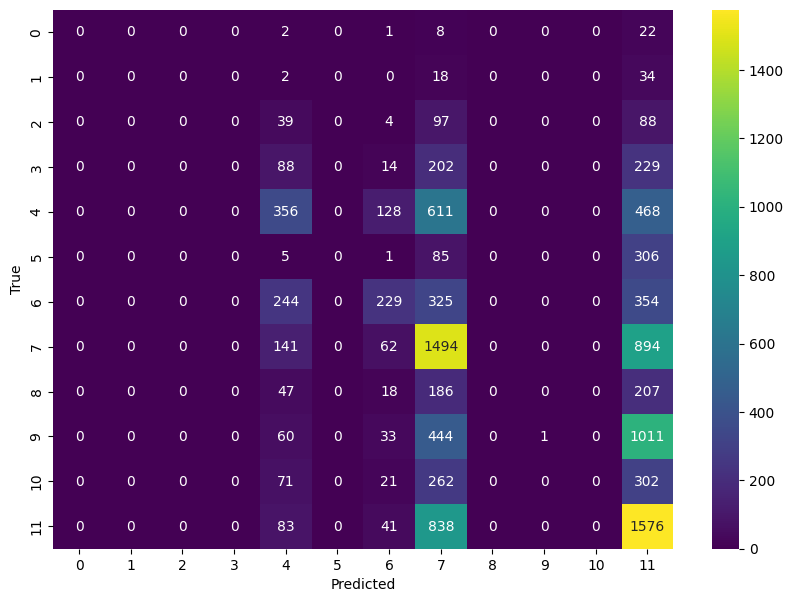

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,7))
sns.heatmap(confusion_matrix(y_test, y_pred_classes), annot=True, fmt="d", cmap="viridis")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [ ]:
text_input = input("Entrer un texte : ")

encoded = tokenizer(
    text_input,
    max_length=MAX_LEN,
    padding='max_length',
    truncation=True,
    return_tensors='tf'
)

prediction = model.predict({
    'input_ids': encoded['input_ids'],
    'attention_mask': encoded['attention_mask']
})[0]

# récupérer les labels réels
label_list = list(df['label'].cat.categories)

for l, p in zip(label_list, prediction):
    print(f"{l}: {p*100:.2f}%")
